<div class="alert alert-success">
    <h1>Assignment 1: Deep Learning</h1>
    <h3 align='center'>Computational Intelligence (4032-01)</h3>
    <h5 align='center'>Instructor: Dr.Samane Hosseini</h5>
    <h5 align='center'>TA: Arash Azhand</h5>
</div>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# 1. Generate Dataset

In [2]:
def load_moons_dataset():
    # TODO: Generate a dataset with make_moons (2000 samples, noise=0.3, random_state=42)
    
    # HINT:
    # 1. Use make_moons from sklearn.datasets.
    X, y = make_moons(n_samples=2000, noise=0.3, random_state=42)
    # 2. Convert X, y into PyTorch tensors of type torch.float32.  
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32) 
    
    return X, y

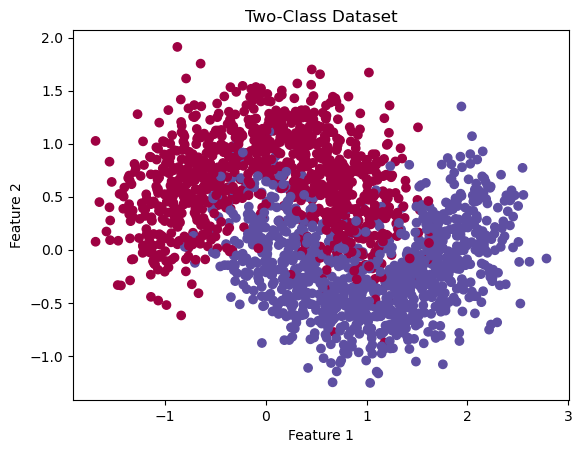

In [3]:
X, y = load_moons_dataset()

plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), cmap=plt.cm.Spectral)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Two-Class Dataset")
plt.show()

**Desired Output:**

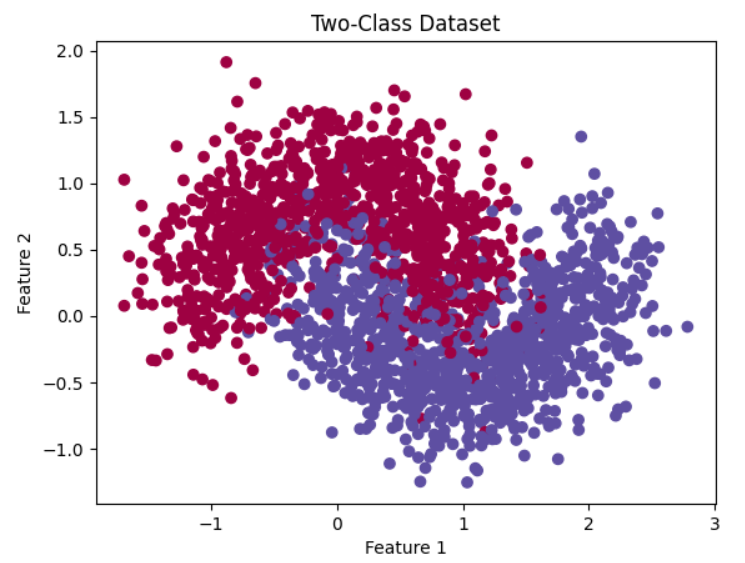

# 2. Define Networks

In [4]:
# Define an underfitting model with one hidden layer and too few neurons (3 or 5)
class UnderfitNeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(UnderfitNeuralNet, self).__init__()
        # TODO: Define a small neural network with just one hidden layer
        
        # HINT:
        # 1. First layer: input_dim → 3 neurons 
        self.fc1 = nn.Linear(input_dim, 3)
        # 2. Output layer: 3 neurons → 1 neuron 
        self.fc2 = nn.Linear(3, 1)
        
        
        

    def forward(self, x):
        # TODO: Implement forward pass using ReLU and Sigmoid
        
        # HINT:
        # 1. Apply ReLU on the first layer.
        x = torch.relu(self.fc1(x))
        # 2. Apply Sigmoid on the final output layer.
        x = torch.sigmoid(self.fc2(x))

        return x

In [5]:
# Define an overfitting model with more than 4 layers and too many neurons in each layer eg:(128, 64, 32)
class OverfitNeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(OverfitNeuralNet, self).__init__()
        # TODO: Define a deep neural network with multiple layers
        
        # HINT:
        # 1. First hidden layer: input_dim → 128 neurons 

        self.fc1 = nn.Linear(input_dim, 128)
        # 2. Second hidden layer: 128 → 64 neurons 
        self.fc2 = nn.Linear(128, 64)
        # 3. Third hidden layer: 64 → 32 neurons 
        self.fc3 = nn.Linear(64, 32)
        # 3. Fourth hidden layer: 32 → 16 neurons
        self.fc4 = nn.Linear(32, 16)
        # 4. Output layer: 16 → 1 neuron 
        self.fc5 = nn.Linear(16, 1)

    def forward(self, x):
        # TODO: Implement forward pass using ReLU and Sigmoid
        
        # HINT:
        # 1. Apply ReLU on all hidden layers.
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        # 2. Apply Sigmoid on the final output layer.
        x = torch.sigmoid(self.fc5(x))
        
        return x

# 3. Move data and models to CUDA (faster training with GPU)

In [6]:
# Ensure CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cpu


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=86)

# TODO: Move data to CUDA 

# HINT:
# 1. Use `.to(device)` to move X_train, X_test, y_train, y_test to the same device.
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)


In [8]:
# TODO: Move the instances of models to the specified device (GPU)
# Hint: You have already defined 'device' earlier.
# Use the `.to(device)` method to move both the underfit and overfit models to the same device as the data.

simple_model = UnderfitNeuralNet(input_dim=2).to(device)
complicated_model = OverfitNeuralNet(input_dim=2).to(device)

In [9]:
# You can see a summary of yor model along with the number of parameters it has
#%pip install torchsummary # !pip install torchsummary --> run this in google colab
from torchsummary import summary
print("Simple Model Summary:")
summary(simple_model, input_size=(2,))
print("Complex Model Summary:")
summary(complicated_model, input_size=(2,))

Simple Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]               9
            Linear-2                    [-1, 1]               4
Total params: 13
Trainable params: 13
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
Complex Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             384
            Linear-2                   [-1, 64]           8,256
            Linear-3                   [-1, 32]           2,080
            Linear-4                   [-1, 16]             528
      

Desired Output:

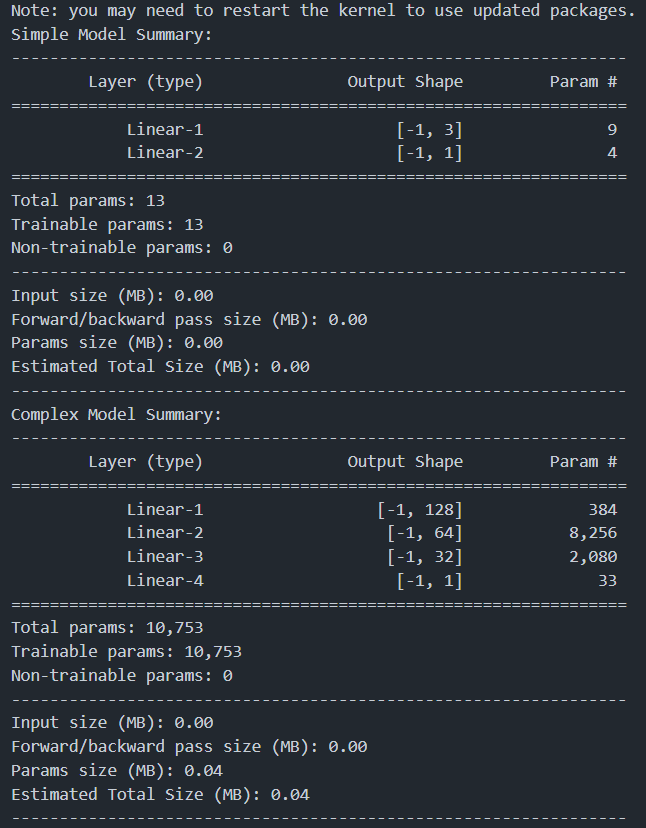

# 4. Train 

In [10]:
def train(model, X_train, y_train, num_epochs=1000, batch_size=32, lr=0.01, lambda_reg=0.01, regularization_type=None):
    # TODO: Ensure the model is in training mode
    # This is necessary because some layers (like dropout or batch normalization) behave differently in training vs. evaluation mode.
    model.train()
    # TODO: Define the loss function
    # Hint: We are using Binary Cross Entropy (BCE) since this is a binary classification problem.
    loss_function = nn.BCELoss()

    # TODO: Define the optimizer
    # Hint: Adam is used here, but you could experiment with other optimizers like SGD or RMSprop.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # TensorDataset helps us manage input (X) and target (y) pairs in batches.
    dataset = TensorDataset(X_train, y_train)  

    # DataLoader splits the dataset into batches and shuffles them for better training performance.
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)  

            # TODO: Reset the gradients before backpropagation
            # Hint: PyTorch accumulates gradients by default, so we need to clear them at the start of each batch.
            optimizer.zero_grad()
            # TODO: Perform forward pass
            # Hint: Pass the input through the model to get predictions.
            outputs = model(inputs)

            # TODO: Compute the loss
            # Hint: Make sure the shapes match. if didn't match, you can use outputs.squeeze() which ensures it's the same shape as targets.
            outputs = outputs.squeeze()  # Ensure the output shape matches targets
            loss = loss_function(outputs, targets)

            # TODO: Implement L1 regularization if selected
            if regularization_type == "L1":
                # Hint: L1 regularization adds the absolute value of the weights to the loss.
                # you can access the model parameters with `model.parameters()`
                l1_reg = lambda_reg * sum(torch.abs(param).sum() for param in model.parameters())
                loss += l1_reg

            # TODO: Implement L2 regularization if selected
            elif regularization_type == "L2":
                # Hint: L2 regularization adds the squared value of the weights to the loss.
                # you can access the model parameters with `model.parameters()`
                l2_reg = lambda_reg * sum(torch.norm(param) ** 2 for param in model.parameters())
                loss += l2_reg

            # TODO: Compute gradients using backpropagation
            # Hint: This step calculates how each weight should be updated.
            loss.backward()
            # TODO: Update model parameters
            # Hint: This applies the calculated gradients to update the model weights.
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        if epoch % 100 == 0:    
            print(f"epoch {epoch}, loss: {epoch_loss}")

    return model  

In [11]:
# NOTE: Do not make any changes here
def plot_decision_boundary(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100), torch.linspace(y_min, y_max, 100))
    xx, yy = xx.to(device), yy.to(device)
    
    with torch.no_grad():
        Z = model(torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1)).cpu()
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx.cpu().numpy(), yy.cpu().numpy(), Z.numpy(), levels=[0, 0.5, 1], alpha=0.6)
    plt.scatter(X.cpu()[:, 0], X.cpu()[:, 1], c=y.cpu().numpy().flatten(), edgecolor='k')
    plt.title(title)
    plt.show()

# 5. Train Models with Different Configurations and Analyze Their Effects

### Experiment 1: Train the Models Without Regularization  (This is done for you)
- **Train both `UnderfitNeuralNet` and `OverfitNeuralNet` models without any regularization.**  
- **Hint:** Use the existing training function and evaluate their performance. Observe if the overfit model memorizes the training data.  

### Experiment 2: Apply L1 Regularization  
- **Modify the training to include L1 regularization.**  
- **Hint:** Add an L1 penalty term (`lambda_reg * sum(abs(param))`) to the loss function.  
- **Analyze:** Does it improve generalization? Do model weights become sparse?  

### Experiment 3: Apply L2 Regularization  
- **Modify the training function to include L2 regularization.**  
- **Hint:** Add an L2 penalty term (`lambda_reg * sum(param^2)`) to the loss function.  
- **Analyze:** Does it help reduce overfitting? Compare with the L1 model.  

### Experiment 4: Add Batch Normalization (for Overfitted Model)  
- **Modify the `OverfitNeuralNet` to include Batch Normalization layers. You can add more layers too.**  
- **Hint:** Use `nn.BatchNorm1d()` after fully connected layers.  
- **Analyze:** Does it stabilize training and improve performance?  

### Experiment 5: Add Dropout (for Overfitted Model) (EXTRA POINT)
- **Modify the `OverfitNeuralNet` to include Dropout layers.**  
- **Hint:** Use `nn.Dropout(p=0.5)` before activation functions.  
- **Analyze:** Does it help prevent overfitting? Compare decision boundaries.  

### Final Step: Compare and Interpret the Results  
- **Evaluate accuracy on test data for each experiment.**  
- **Plot the decision boundary for each model using the provided function.**  
- **Compare and discuss:**  
  - Which regularization method improved generalization the most?  
  - Did dropout or batch normalization help the overfitted model?  
  - How do underfitting and overfitting look in the plots?  

**Your goal:** Experiment, analyze, and understand how these techniques impact deep learning models!

In [12]:
# Function to evaluate the model on test data
def evaluate_model(model, X_test, y_test, criterion, model_name):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(X_test).squeeze()
        loss = criterion(outputs, y_test.squeeze())
        # Convert logits to binary labels
        predictions = (outputs > 0.5).float()
        accuracy = (predictions == y_test).float().mean()

    print(f"{model_name} - Test Loss: {loss.item():.4f}, Test Accuracy: {accuracy.item() * 100:.2f}%")
    return loss.item(), accuracy.item()

## Expriment 1: Train the Models Without Regularization

**Expectation**:
I expect the complex model to perform better on the training set and achieve lower loss. However, on the test set, the simpler model should generalize better.

Training too simple model without regularization...
epoch 0, loss: 0.6302530705928803
epoch 100, loss: 0.3368516829609871
epoch 200, loss: 0.33635206907987597
epoch 300, loss: 0.3369456923007965
epoch 400, loss: 0.33584606111049653
epoch 500, loss: 0.33768363535404206
epoch 600, loss: 0.3361003637313843
epoch 700, loss: 0.33686447113752366
epoch 800, loss: 0.3360858753323555
epoch 900, loss: 0.3360482761263847
Training complicated model without regularization...
epoch 0, loss: 0.3932942947745323
epoch 100, loss: 0.19796236887574195
epoch 200, loss: 0.18773535929620266
epoch 300, loss: 0.18739428102970124
epoch 400, loss: 0.17400134563446046
epoch 500, loss: 0.1787967376038432
epoch 600, loss: 0.16353125378489494
epoch 700, loss: 0.29073665261268616
epoch 800, loss: 0.28207253471016885
epoch 900, loss: 0.27735281486064195


/home/xmojtabw/.conda/envs/readyenv/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


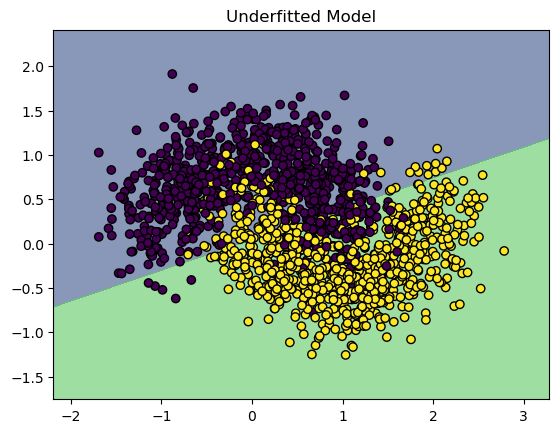

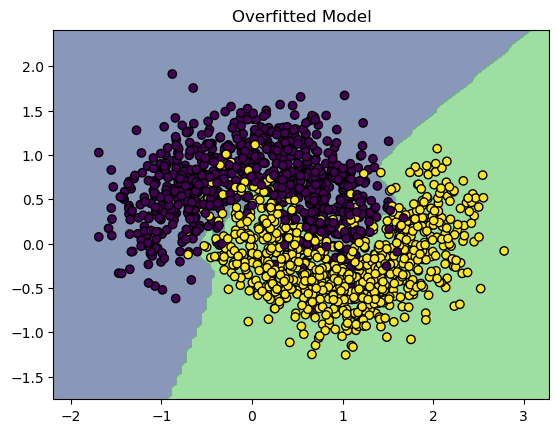

---------***eval***---------
Underfitted Model - Test Loss: 0.3010, Test Accuracy: 87.50%
Overfitted Model - Test Loss: 0.5882, Test Accuracy: 88.50%


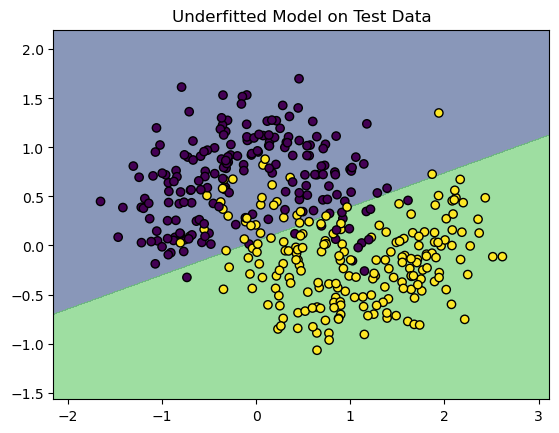

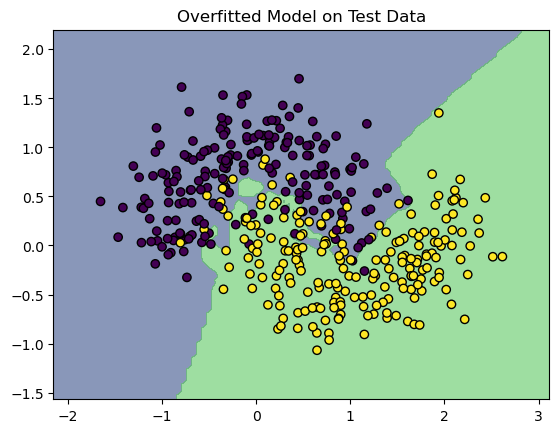

In [13]:
print("Training too simple model without regularization...")
model_underfit = train(simple_model, X_train, y_train, regularization_type=None)
print("Training complicated model without regularization...")
model_overfit = train(complicated_model, X_train, y_train, regularization_type=None)
plot_decision_boundary(X_train, y_train, model_underfit,
                       title="Underfitted Model")
plot_decision_boundary(X_train, y_train, model_overfit,
                       title="Overfitted Model")

print ("---------***eval***---------")
# Evaluate on Test Data
evaluate_model(model_underfit, X_test, y_test,
               nn.BCELoss(), "Underfitted Model")
evaluate_model(model_overfit, X_test, y_test, nn.BCELoss(), "Overfitted Model")

# Plot decision boundaries for test data
plot_decision_boundary(X_test, y_test, model_underfit,
                       title="Underfitted Model on Test Data")
plot_decision_boundary(X_test, y_test, model_overfit,
                       title="Overfitted Model on Test Data")

### Results:
As expected, the complex model achieved a lower loss on the training set, while the simpler model performed better on the test set with lower test loss. The decision boundary of the simple model is very smooth and linear, whereas the complex model’s decision boundary is much more flexible and curved. In the test data visualization, the complex model shows signs of memorization — such as purple regions inside green areas — indicating clear overfitting.

## Experiment 2: Apply L1 Regularization 

**Expectation**:
I expect the complex model to perform better with L1 regularization due to reduced overfitting.

Training too simple model with regularization L1...


epoch 0, loss: 0.6748947119712829
epoch 100, loss: 0.4214591521024704
epoch 200, loss: 0.4213495486974716
epoch 300, loss: 0.4215174740552902
epoch 400, loss: 0.4221366930007935
epoch 500, loss: 0.4218358075618744
epoch 600, loss: 0.42280676305294035
epoch 700, loss: 0.42145565390586853
epoch 800, loss: 0.42194634914398194
epoch 900, loss: 0.4227615574002266
Training complicated model with regularization L1...
epoch 0, loss: 2.1810912704467773
epoch 100, loss: 0.8370769405364991
epoch 200, loss: 0.8372546291351318
epoch 300, loss: 0.8371518850326538
epoch 400, loss: 0.837003390789032
epoch 500, loss: 0.8368870782852172
epoch 600, loss: 0.8371146726608276
epoch 700, loss: 0.8369982624053955
epoch 800, loss: 0.8368845391273498
epoch 900, loss: 0.8372133958339691


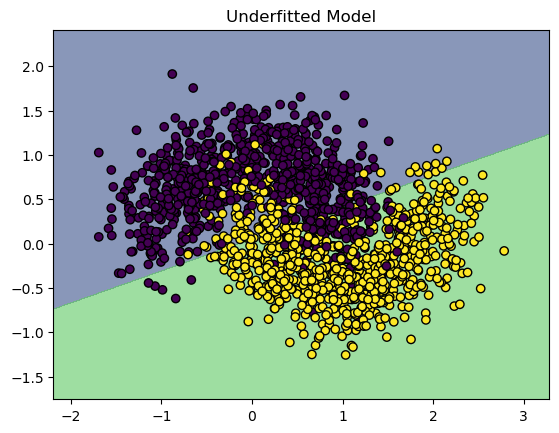

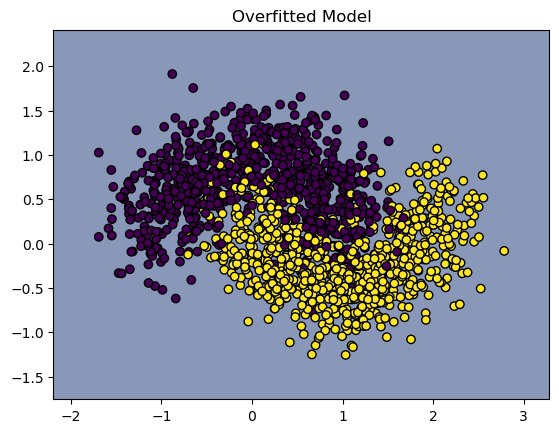

---------***eval***---------
Underfitted Model - Test Loss: 0.3144, Test Accuracy: 87.75%
Overfitted Model - Test Loss: 0.6932, Test Accuracy: 48.25%


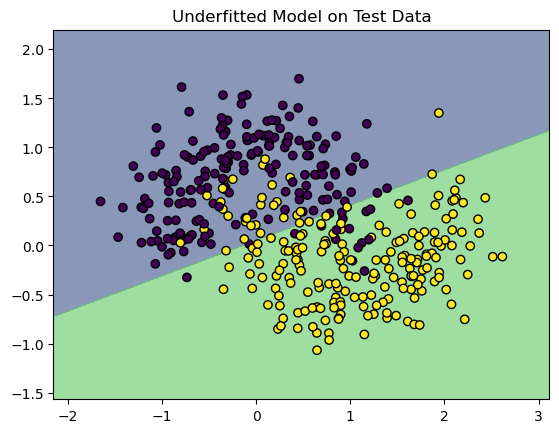

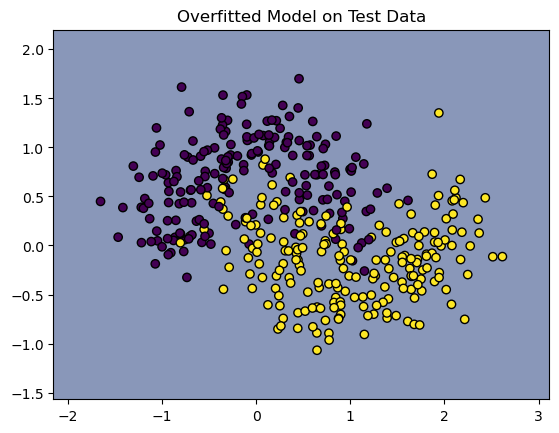

In [14]:
# create new instances of the models
simple_model = UnderfitNeuralNet(input_dim=2).to(device)
complicated_model = OverfitNeuralNet(input_dim=2).to(device)
print("Training too simple model with regularization L1...")
model_underfit = train(simple_model, X_train, y_train, regularization_type='L1')
print("Training complicated model with regularization L1...")
model_overfit = train(complicated_model, X_train, y_train, regularization_type='L1')
plot_decision_boundary(X_train, y_train, model_underfit,
                       title="Underfitted Model")
plot_decision_boundary(X_train, y_train, model_overfit,
                       title="Overfitted Model")

print("---------***eval***---------")

# Evaluate on Test Data
evaluate_model(model_underfit, X_test, y_test,
               nn.BCELoss(), "Underfitted Model")
evaluate_model(model_overfit, X_test, y_test, nn.BCELoss(), "Overfitted Model")

# Plot decision boundaries for test data
plot_decision_boundary(X_test, y_test, model_underfit,
                       title="Underfitted Model on Test Data")
plot_decision_boundary(X_test, y_test, model_overfit,
                       title="Overfitted Model on Test Data")

### Result:
The results were surprising. Both models suffered a significant performance drop. The complex model classified nearly all samples into a single class, likely because many of its weights were driven to zero. The simple model also became too simplistic and failed to separate the classes effectively. Clear signs of underfitting were observed in both models.

## Experiment 3: Apply L2 Regularization  

**Expectation**:
I expect L2 regularization to simplify the model, but not as aggressively as L1, meaning it should retain more useful parameters.

Training too simple model with regularization L2...
epoch 0, loss: 0.6730643439292908
epoch 100, loss: 0.4224861770868301
epoch 200, loss: 0.4217912709712982
epoch 300, loss: 0.42272336065769195
epoch 400, loss: 0.4224734354019165
epoch 500, loss: 0.42252728313207627
epoch 600, loss: 0.4228489810228348
epoch 700, loss: 0.4213982611894608
epoch 800, loss: 0.42391584038734437
epoch 900, loss: 0.42194257557392123
Training complicated model with regularization L2...
epoch 0, loss: 0.8256566476821899
epoch 100, loss: 0.4402120923995972
epoch 200, loss: 0.43248202562332155
epoch 300, loss: 0.43216016709804533
epoch 400, loss: 0.4348247402906418
epoch 500, loss: 0.4308914637565613
epoch 600, loss: 0.4328679299354553
epoch 700, loss: 0.42726706802845
epoch 800, loss: 0.43226406097412107
epoch 900, loss: 0.42598375856876375
---------***eval***---------
Underfitted Model - Test Loss: 0.3229, Test Accuracy: 87.25%
Overfitted Model - Test Loss: 0.2381, Test Accuracy: 90.25%


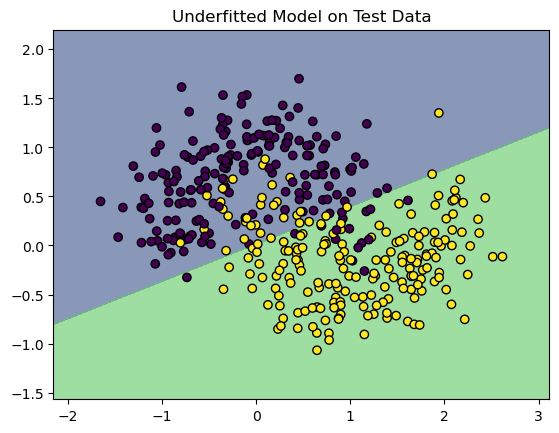

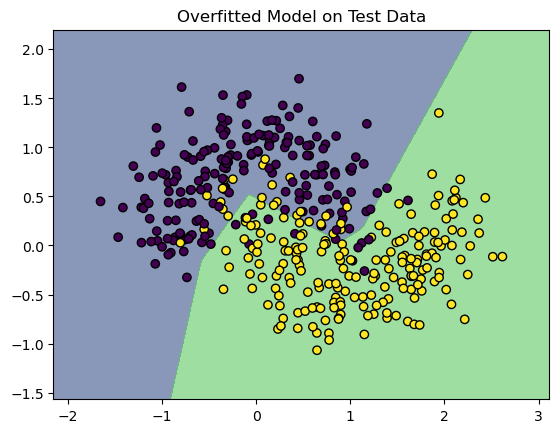

In [15]:
# create new instances of the models
simple_model = UnderfitNeuralNet(input_dim=2).to(device)
complicated_model = OverfitNeuralNet(input_dim=2).to(device)
print("Training too simple model with regularization L2...")
model_underfit = train(simple_model, X_train, y_train,
                       regularization_type='L2')
print("Training complicated model with regularization L2...")
model_overfit = train(complicated_model, X_train,
                      y_train, regularization_type='L2')

print("---------***eval***---------")

# Evaluate on Test Data
evaluate_model(model_underfit, X_test, y_test,
               nn.BCELoss(), "Underfitted Model")
evaluate_model(model_overfit, X_test, y_test, nn.BCELoss(), "Overfitted Model")

# Plot decision boundaries for test data
plot_decision_boundary(X_test, y_test, model_underfit,
                       title="Underfitted Model on Test Data")
plot_decision_boundary(X_test, y_test, model_overfit,
                       title="Overfitted Model on Test Data")

### Result 

L2 regularization performed significantly better than L1. It improved the generalization of the complex model and increased its accuracy on the test set without collapsing its capacity to learn. The model became simpler but still expressive enough to capture important patterns.

## Experiment 4: Add Batch Normalization (for Overfitted Model)  
**Expectation:**
I expect the learning process to become faster (in terms of convergence) and more stable overall.

In [16]:
class DropoutOverfitNeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(DropoutOverfitNeuralNet, self).__init__()
        # Define linear layers
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)

        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)

        self.fc4 = nn.Linear(32, 16)
        self.bn4 = nn.BatchNorm1d(16)

        self.fc5 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.bn1(self.fc1(x))
        x = torch.relu(x)

        x = self.bn2(self.fc2(x))
        x = torch.relu(x)

        x = self.bn3(self.fc3(x))
        x = torch.relu(x)

        x = self.bn4(self.fc4(x))
        x = torch.relu(x)

        x = torch.sigmoid(self.fc5(x))  # Output layer

        return x

Training batch normalized complicated model with regularization L2...
epoch 0, loss: 2.346326804161072
epoch 100, loss: 0.35825586318969727
epoch 200, loss: 0.3689896655082703
---------***eval***---------
Batch Normalized Complicated Model - Test Loss: 0.3178, Test Accuracy: 89.75%


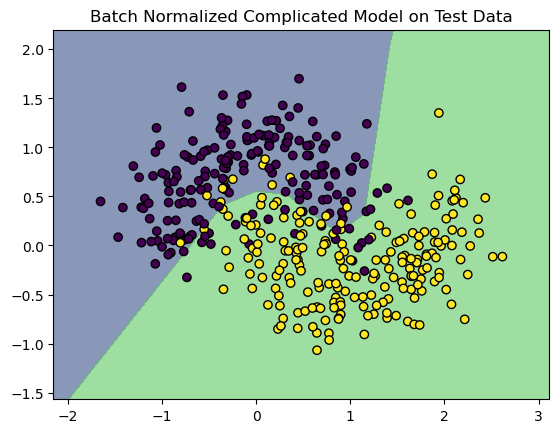

In [17]:
# create new instances of the models

batch_normalized_complicated_model = DropoutOverfitNeuralNet(input_dim=2).to(device)
print("Training batch normalized complicated model with regularization L2...")
batch_normalized_complicated_model = train(batch_normalized_complicated_model, X_train,
                      y_train, regularization_type='L2',num_epochs=201)

print("---------***eval***---------")

# Evaluate on Test Data
evaluate_model(batch_normalized_complicated_model, X_test, y_test, nn.BCELoss(), "Batch Normalized Complicated Model")

# Plot decision boundaries for test data
plot_decision_boundary(X_test, y_test, batch_normalized_complicated_model,
                       title="Batch Normalized Complicated Model on Test Data")

### Result

Although each epoch took slightly more time due to the extra computation, the model converged in far fewer epochs. Training became more stable, and the model achieved a lower loss than before. Batch normalization clearly helped optimize learning efficiency and reduced overfitting.

## Experiment 5: Add Dropout (for Overfitted Model) 

**Expectation:**
I expect dropout to help reduce overfitting by preventing the model from relying too heavily on specific neurons.

In [18]:
class DropoutOverfitNeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(DropoutOverfitNeuralNet, self).__init__()
        # Define linear + batch norm + dropout layers
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(p=0.2)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(p=0.5)

        self.fc4 = nn.Linear(32, 16)
        self.bn4 = nn.BatchNorm1d(16)
        self.dropout4 = nn.Dropout(p=0.2)

        self.fc5 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.bn1(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(x)

        x = self.bn2(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(x)

        x = self.bn3(self.fc3(x))
        x = self.dropout3(x)
        x = torch.relu(x)

        x = self.bn4(self.fc4(x))
        x = self.dropout4(x)
        x = torch.relu(x)

        x = torch.sigmoid(self.fc5(x))  # Output layer

        return x

Training complicated model with Dropout...
epoch 0, loss: 0.43118545204401015
epoch 100, loss: 0.2817782613635063
epoch 200, loss: 0.2578371270000935
---------***eval***---------
Complicated Model with Dropout - Test Loss: 0.2359, Test Accuracy: 89.50%


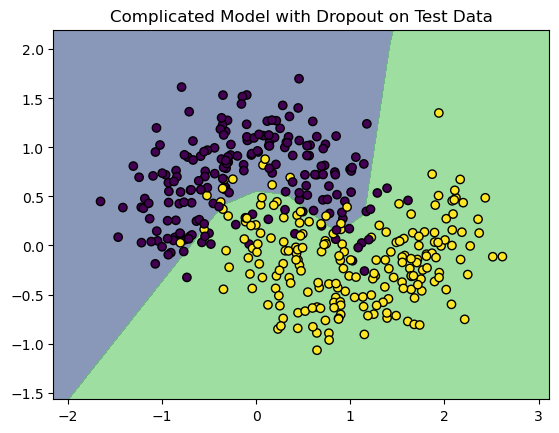

In [19]:
# create new instances of the models

dropout_complicated_model = DropoutOverfitNeuralNet(
    input_dim=2).to(device)
print("Training complicated model with Dropout...")
dropout_complicated_model = train(dropout_complicated_model, X_train,
                                           y_train, regularization_type=None, num_epochs=201)

print("---------***eval***---------")

# Evaluate on Test Data
evaluate_model(dropout_complicated_model, X_test, y_test,
               nn.BCELoss(), "Complicated Model with Dropout")

# Plot decision boundaries for test data
plot_decision_boundary(X_test, y_test, batch_normalized_complicated_model,
                       title="Complicated Model with Dropout on Test Data")

### Result 

As observed, dropout both accelerated learning and improved generalization. It prevented overfitting effectively, and the model achieved a good performance on the test data. The decision boundaries also became more robust compared to the first model(overfitted model)